### Consumo de cerveja em São Paulo

In [50]:
# Importando as bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# Importando o dataset em CSV

df = pd.read_csv('Consumo_cerveja.csv')

In [52]:
# Obtendo informações sobre o número de linhas e colunas

df.shape

(941, 7)

In [53]:
# Analisando as 15 primeiras linhas do dataset

df.head(15)

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900
5,2015-01-06,"23,78","20,1","30,5","12,2",0.0,28.218
6,2015-01-07,24,"19,5","33,7",0,0.0,29.732
7,2015-01-08,"24,9","19,5","32,8","48,6",0.0,28.397
8,2015-01-09,"28,2","21,9",34,"4,4",0.0,24.886
9,2015-01-10,"26,76","22,1","34,2",0,1.0,37.937


#### Limpando e formatando o dataset

In [54]:
# Somando a quantidade de valores NaN

df.isnull().sum()

Data                           576
Temperatura Media (C)          576
Temperatura Minima (C)         576
Temperatura Maxima (C)         576
Precipitacao (mm)              576
Final de Semana                576
Consumo de cerveja (litros)    576
dtype: int64

In [55]:
# Percentual de valores NaN por coluna

df.isna().sum()/(len(df))*100

Data                           61.211477
Temperatura Media (C)          61.211477
Temperatura Minima (C)         61.211477
Temperatura Maxima (C)         61.211477
Precipitacao (mm)              61.211477
Final de Semana                61.211477
Consumo de cerveja (litros)    61.211477
dtype: float64

In [56]:
# Retirando os valores NaN do dataset

df.dropna(inplace=True)
df.isnull().sum()

Data                           0
Temperatura Media (C)          0
Temperatura Minima (C)         0
Temperatura Maxima (C)         0
Precipitacao (mm)              0
Final de Semana                0
Consumo de cerveja (litros)    0
dtype: int64

In [57]:
# Observando as informações do dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         365 non-null    object 
 1   Temperatura Media (C)        365 non-null    object 
 2   Temperatura Minima (C)       365 non-null    object 
 3   Temperatura Maxima (C)       365 non-null    object 
 4   Precipitacao (mm)            365 non-null    object 
 5   Final de Semana              365 non-null    float64
 6   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(2), object(5)
memory usage: 22.8+ KB


In [58]:
# Transformando a data do dataset em datetime

df['Data'] = pd.to_datetime(df['Data'])

In [59]:
# Obtendo o tipo das colunas

df.columns

Index(['Data', 'Temperatura Media (C)', 'Temperatura Minima (C)',
       'Temperatura Maxima (C)', 'Precipitacao (mm)', 'Final de Semana',
       'Consumo de cerveja (litros)'],
      dtype='object')

In [60]:
# Transformando os valores para o tipo float e trocando as vírgulas por ponto

df['Temperatura Media (C)'] = df['Temperatura Media (C)'].str.replace(',', '.').astype('float')
df['Temperatura Minima (C)'] = df['Temperatura Minima (C)'].str.replace(',', '.').astype('float')
df['Temperatura Maxima (C)'] = df['Temperatura Maxima (C)'].str.replace(',', '.').astype('float')
df['Precipitacao (mm)'] = df['Precipitacao (mm)'].str.replace(',', '.').astype('float')

In [61]:
# Usando o método info para confirmar a conversão do tipo das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Data                         365 non-null    datetime64[ns]
 1   Temperatura Media (C)        365 non-null    float64       
 2   Temperatura Minima (C)       365 non-null    float64       
 3   Temperatura Maxima (C)       365 non-null    float64       
 4   Precipitacao (mm)            365 non-null    float64       
 5   Final de Semana              365 non-null    float64       
 6   Consumo de cerveja (litros)  365 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 22.8 KB


In [62]:
# Aplicando o método descibe para ver as estatísticas do dataset

df.describe()

,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25.401367
std,3.180108,2.826185,4.317366,12.417844,0.452001,4.399143
min,12.900000,10.600000,14.500000,0.000000,0.000000,14.343000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22.008000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24.867000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28.631000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37.937000


In [63]:
# Plotando os gráficos com o seaborn para análise

sns.set()

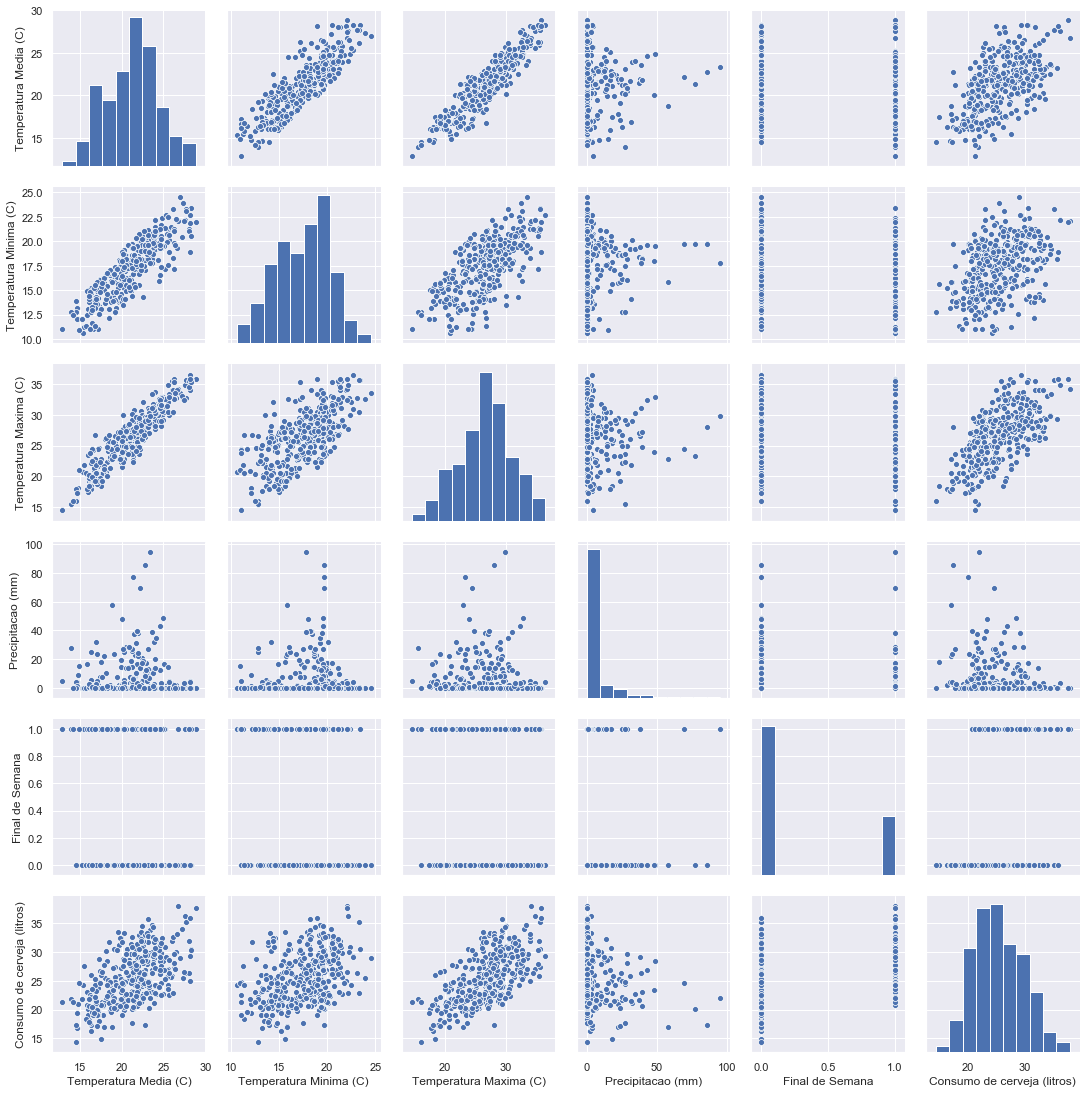

In [64]:
sns.pairplot(df)